# UR5e Cinemáticas
### Lismar de Jesus Oliveira

In [25]:
import numpy as np
from joint import Joint
from ur5e import UR5e
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
pi = np.pi


## Definição do modelo UR5e com os paramtros da tabela dh informado pelo link abaixo
### https://www.universal-robots.com/articles/ur/application-installation/dh-parameters-for-calculations-of-kinematics-and-dynamics/


In [26]:
theta1 = 0
theta2 = 0
theta3 = 0
theta4 = 0
theta5 = 0
theta6 = 0
jointNames = ['Shoulder pan joint', 'Shoulder lift joint', 'Elbow joint', 'Wrist 1 joint', 'Wrist 2 joint', 'Wrist 3 joint']
joint1 = Joint(theta1, 0, 0.1625, pi/2, 3.761, [[0, -0.02561, 0.00193]])
joint2 = Joint(theta2, -0.425, 0, 0, 8.058, [0.2125, 0, 0.11336])
joint3 = Joint(theta3, -0.3922, 0, 0, 2.846, [0.15, 0.0, 0.0265])
joint4 = Joint(theta4, 0, 0.1333, pi/2, 1.37, [0, 0, 0.01])
joint5 = Joint(theta5, 0, 0.0997, -pi/2, 1.3, [0, 0, 0.01])
joint6 = Joint(theta6, 0, 0.0996, 0, 0.365, [0, 0, -0.001159])

ur5 = UR5e(joint1, joint2, joint3, joint4, joint5, joint6)

In [27]:
def dhParams(ur5):
    dh = [
                {
                    "alpha": 0,
                    "a": 0,
                    "distance": ur5.joint1.distance,
                    "theta": ur5.joint1.theta,
                },
                {
                    "alpha": pi / 2,
                    "a": 0,
                    "distance": 0,
                    "theta": ur5.joint2.theta,
                },
                {
                    "alpha": 0,
                    "a": ur5.joint2.a,
                    "distance": 0,
                    "theta": ur5.joint3.theta,
                },
                {
                    "alpha": 0,
                    "a": ur5.joint3.a,
                    "distance": ur5.joint4.distance,
                    "theta": ur5.joint4.theta,
                },
                {
                    "alpha": pi / 2,
                    "a": 0,
                    "distance": ur5.joint5.distance,
                    "theta": ur5.joint5.theta,
                },
                {
                    "alpha": -pi / 2,
                    "a": 0,
                    "distance": ur5.joint6.distance,
                    "theta": ur5.joint6.theta,
                },
            ]
    return dh

## Calculo da cinemática direta

In [34]:
def generateTMatrix(theta, distance, a, alpha):
        return np.array(
            [[np.cos(theta), -np.sin(theta), 0, a ],
             [np.sin(theta)*np.cos(alpha),
              np.cos(theta)*np.cos(alpha),
              - np.sin(alpha), -np.sin(alpha)*distance ],
             [np.sin(theta)*np.sin(alpha),
             np.cos(theta)*np.sin(alpha),
             np.cos(alpha), np.cos(alpha)*distance ],
             [0, 0, 0, 1], ])

In [36]:
def forwardKinematic(angleJoint1, angleJoint2, angleJoint3, angleJoint4, angleJoint5, angleJoint6):
    ur5.updateJointsPositions(angleJoint1, angleJoint2, angleJoint3, angleJoint4, angleJoint5, angleJoint6)
    dh = dhParams(ur5)
    tMatrix0_6 = np.identity(4)
    for joint in dh:
        tMatrix = generateTMatrix(
            joint['theta'], joint['distance'], joint['a'], joint['alpha'])
        tMatrix0_6 = np.dot(tMatrix0_6, tMatrix)
    return tMatrix0_6
  
tMatrix = forwardKinematic(0,0,pi/2,0,0,0)


## Calculo da cinemática inversa

In [37]:
def setToolPosition(toolPosition):
    return {
        'up': np.array([[0, 1, 0],[0 , 0,1],[1, 0,0]]),
        'down': np.array([[0, -1, 0],[0 , 0,-1],[-1, 0,0]]),
        'right': np.array([[1, 0, 0],[0 , 0,1],[0, 1,0]]),
        'left': np.array([[0, -1, 0],[0 , 0,-1],[-1, 0,0]]),
    }[toolPosition]

In [38]:
def invKinematic(x, y, z, toolPosition):
    results = []
    dh = dhParams(ur5)
    rotation = setToolPosition('up')
    tMatrix = np.vstack((np.hstack((rotation, [[x],[y], [z]])), [0,0,0,1]))
    p0_5 = np.dot(tMatrix, np.array([[0], [0], [-ur5.joint6.distance], [1]]))
    p0_5x = p0_5[0][0]
    p0_5y = p0_5[1][0]
    theta1 = np.arctan2(p0_5y, p0_5x) + np.arccos(dh[3]['distance'] / ((p0_5x ** 2 + p0_5y ** 2) ** (1 / 2))) + pi / 2
    p0_6x = tMatrix[0][3]
    p0_6y = tMatrix[1][3]
    theta5  = np.arccos((p0_6x * np.sin(theta1) - p0_6y * np.cos(theta1) -  dh[3]['distance']) / dh[5]['distance'])
    xoY = tMatrix[0][1]
    yoY = tMatrix[1][1]
    xoX = tMatrix[0][0]
    yoX = tMatrix[1][0]
    theta6 = np.arctan2((-xoY*np.sin(theta1) + yoY*np.cos(theta1)) / np.sin(theta5),  (xoX*np.sin(theta1) - yoX*np.cos(theta1)) / np.sin(theta5))
    tMatrix0_1 = generateTMatrix(theta1, dh[0]['distance'], dh[0]['a'], dh[0]['alpha'])
    tMatrix4_5 = generateTMatrix(theta5, dh[4]['distance'], dh[4]['a'], dh[4]['alpha'])
    tMatrix5_6 = generateTMatrix(theta6, dh[5]['distance'], dh[5]['a'], dh[5]['alpha'])
    tMatrix0_5 = np.dot(tMatrix, np.linalg.inv(tMatrix5_6))
    tMatrix0_4 = np.dot(tMatrix0_5, np.linalg.inv(tMatrix4_5))
    tMatrix1_4 = np.dot(np.linalg.inv(tMatrix0_1), tMatrix0_4)
    p1_4x = tMatrix1_4[0][3]
    p1_4z = tMatrix1_4[2][3]
    p1_4XZ = p1_4x ** 2 + p1_4z ** 2
    a2 = ur5.joint2.a
    a3 = ur5.joint3.a
    theta3 = np.arccos((p1_4XZ - (a2 ** 2) - (a3 ** 2)) / (2 * a2 * a3))
    theta2 = np.arctan2(-p1_4z, -p1_4x) - np.arcsin((-a3*np.sin(theta3))/(p1_4XZ**0.5))
    tMatrix1_2 = generateTMatrix(theta2, dh[1]['distance'], dh[1]['a'], dh[1]['alpha'])
    tMatrix2_3 = generateTMatrix(theta3, dh[2]['distance'], dh[2]['a'], dh[2]['alpha'])
    tMatrix1_3 = np.dot(tMatrix1_2, tMatrix2_3)
    tMatrix0_3 = np.dot(tMatrix0_1, tMatrix1_3)
    tMatrix3_4 = np.dot(np.linalg.inv(tMatrix0_3), tMatrix0_4)
    x3_4x = tMatrix3_4[0][0]
    x3_4y = tMatrix3_4[1][0]
    theta4 = np.arctan2(x3_4y,x3_4x)
    if not np.isnan(theta2):
        tMatrix = forwardKinematic(theta1, theta2, theta3, theta4, theta5, theta6)
        angles = [theta1, theta2, theta3, theta4, theta5, theta6]
        print(angles)
        print(tMatrix)
        return angles
    return []

angles = invKinematic(0.64, 0.35, 0.00, 'up')

[3.319331972660577, -0.4747638997850342, 1.1895830915222294, -0.7148191917371953, 0.17773931907078216, 1.5707963267948966]
[[-1.78032967e-16  1.00000000e+00 -1.60261092e-15  6.40000000e-01]
 [-8.03020664e-17  1.65099969e-15  1.00000000e+00  3.50000000e-01]
 [ 1.00000000e+00  2.31478779e-16  9.37747512e-17  7.87289043e-17]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


## Trajetórias polinomiais cúbicas

In [32]:
totalTime = 2
times = np.arange(0, totalTime, 0.01)
def createCPT(angles):
    q0 = 0
    resultsTPC = []
    for joint in angles:
        qf = joint
        positions= []
        velocitys = [] 
        accelarations = []
        for t in times:
            jointPosition = 3*(qf/4)*(t**2) - (qf/4)*(t**3)
            jointVelocity = (3/2)*qf*t - (3/4)*qf*(t**2)
            jointAcceleration = (3/2)*qf - (3/4)*qf*t
            positions.append(jointPosition)
            velocitys.append(jointVelocity)
            accelarations.append(jointAcceleration)
        resultsTPC.append(
            {   'qf': qf, 
                'positions': positions,
                'velocitys': velocitys,
                'acceletations': accelarations,
                'time': np.arange(0, totalTime, 0.01),
                'q0': q0,
                }
            )
    return resultsTPC
resultsTPC = createCPT(angles)    

## Linear Segments with Parabolic Blends (LSPB)

6


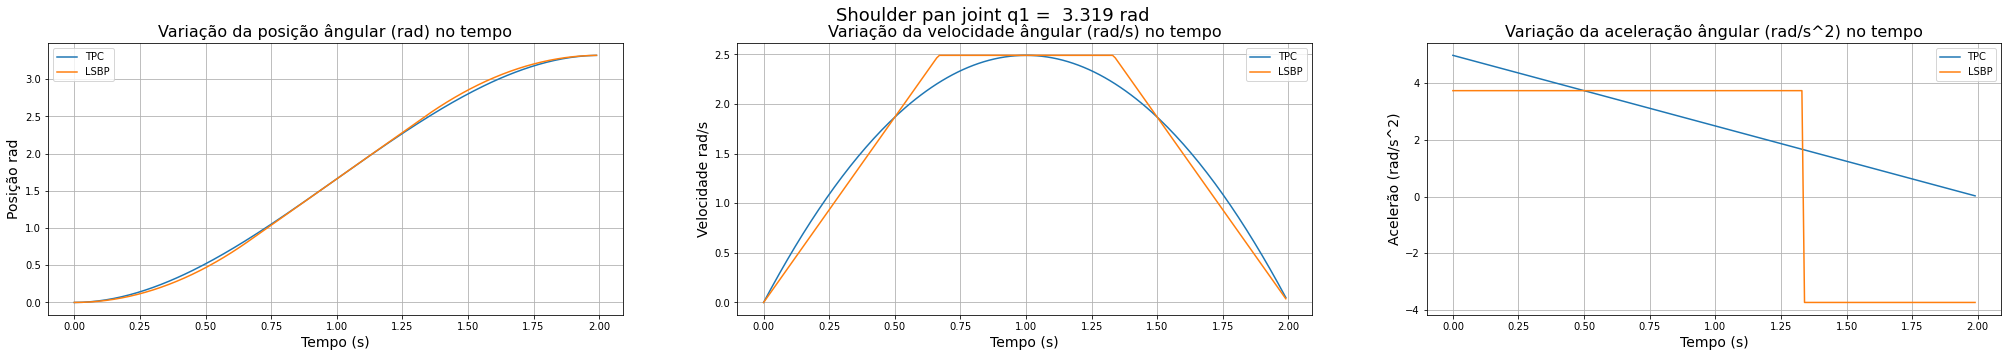

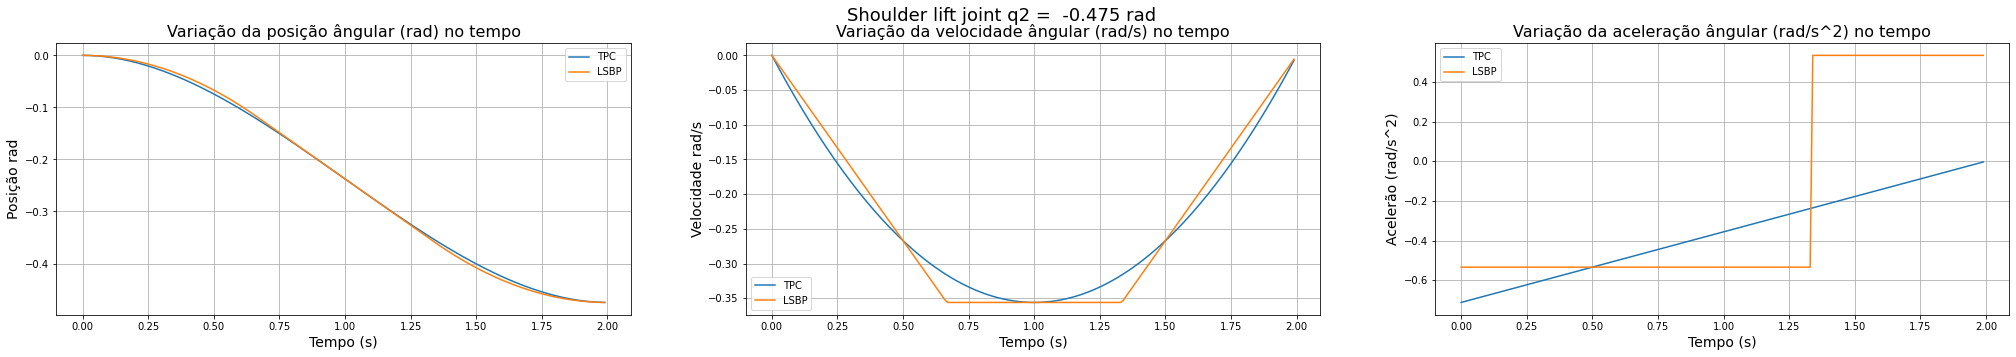

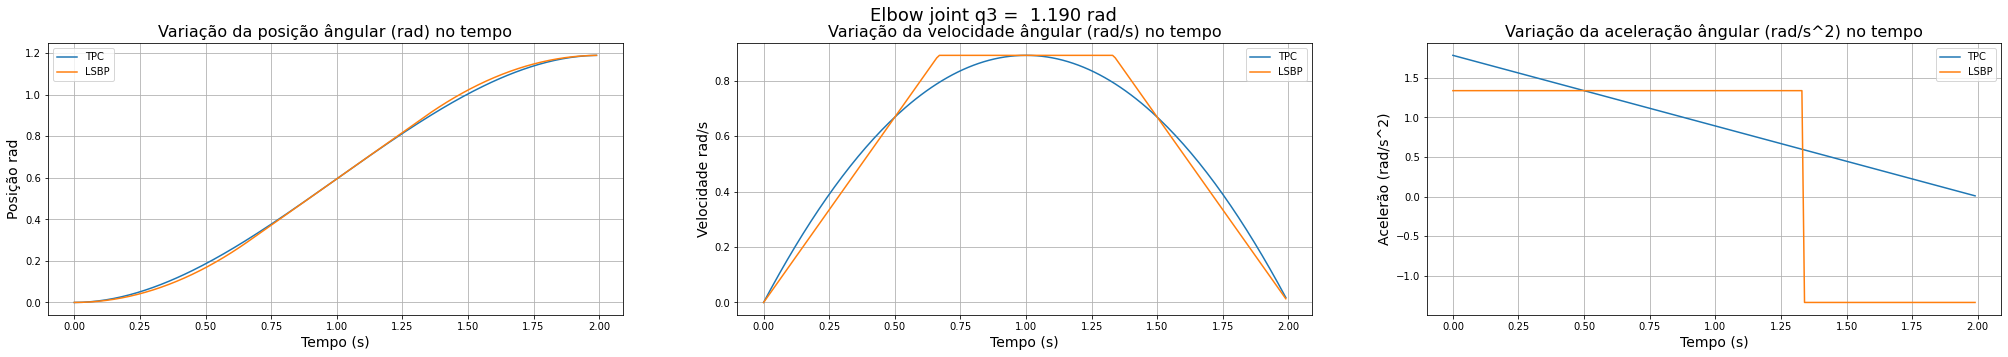

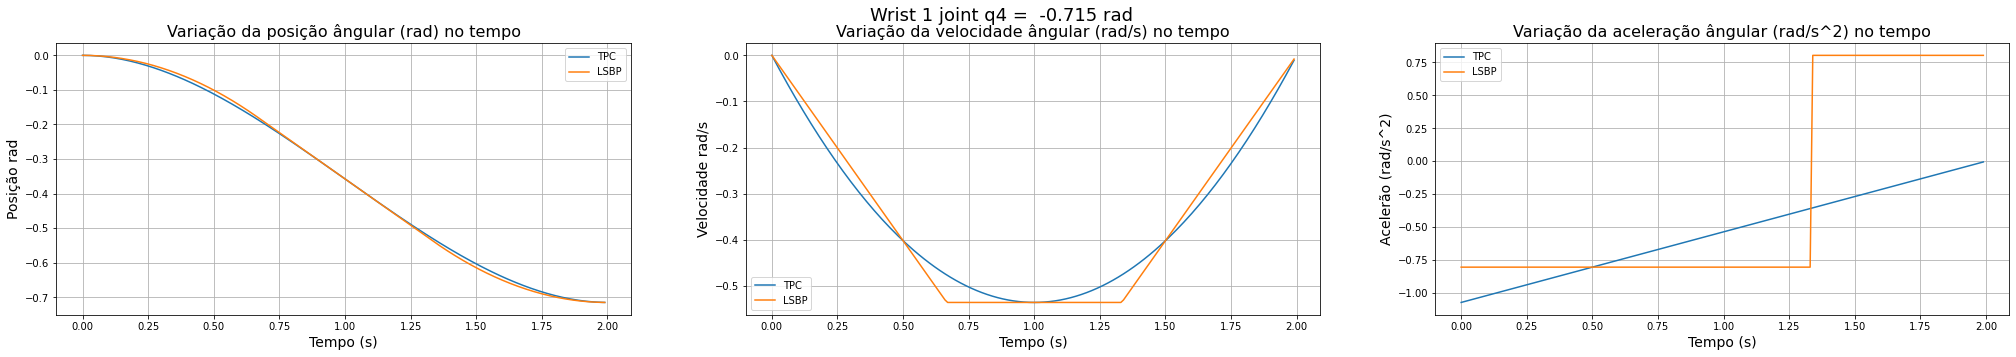

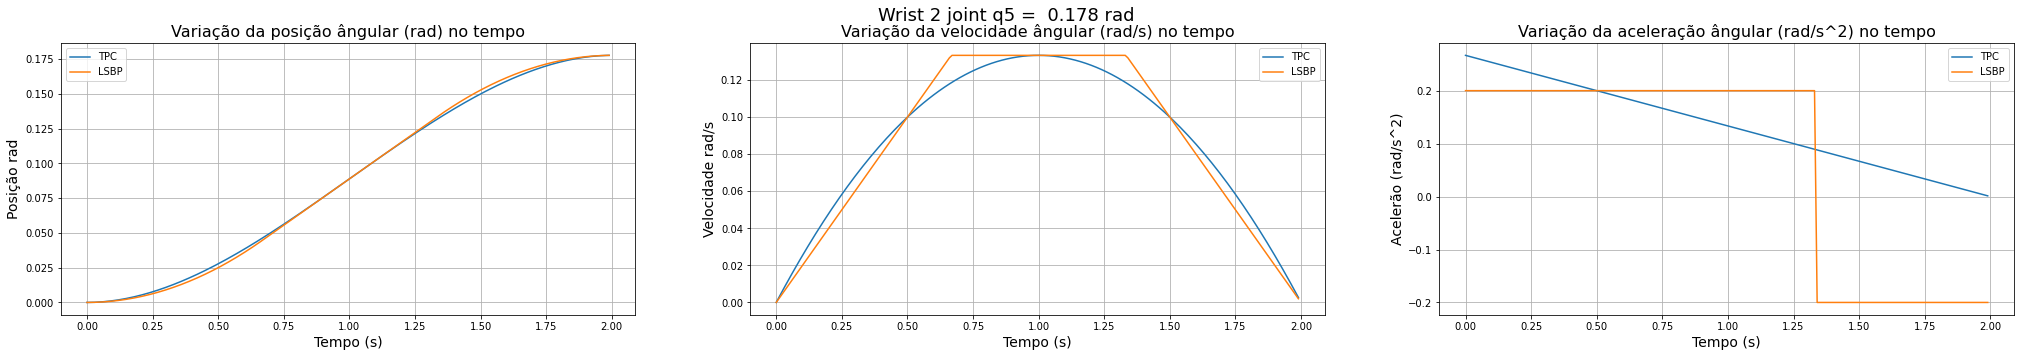

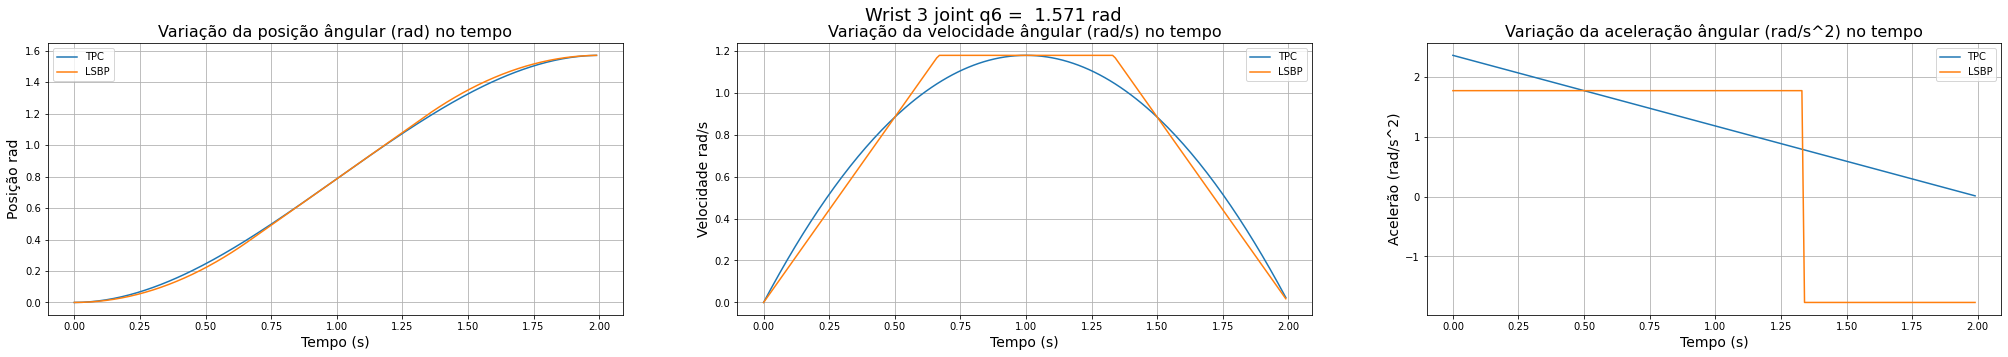

6


In [33]:
def createLSPB(angles):
    resultsLSPB = []
    q0 = 0
    for joint in angles:
        qf = joint
        V = 1.5*(qf - q0)/totalTime
        tb = (q0 - qf + V*totalTime)/V
        alpha = V/tb
        positions= []
        velocitys = [] 
        accelarations = []
        for t in times:
            if t<=tb:
                jointPosition = q0 + (alpha*(t**2))/2
                jointVelocity = alpha*t
                joitAcceleration = alpha
                positions.append(jointPosition)
                velocitys.append(jointVelocity)
                accelarations.append(joitAcceleration)
            elif tb < t and totalTime - tb >= t:
                jointPosition = (qf+q0 - V*totalTime)/2 + V*t
                jointVelocity = V
                joitAcceleration = alpha
                positions.append(jointPosition)
                velocitys.append(jointVelocity)
                accelarations.append(joitAcceleration)
            else:
                jointPosition = qf - alpha*(totalTime**2)/2 + alpha*totalTime*t - (alpha*(t**2))/2
                jointVelocity = alpha*totalTime - alpha*t
                jointAcceleration = -alpha
                positions.append(jointPosition)
                velocitys.append(jointVelocity)
                accelarations.append(jointAcceleration)
        resultsLSPB.append(
        {
            'positions': positions,
            'velocitys': velocitys,
            'acceletations': accelarations,
            'time': np.arange(0, totalTime, 0.01),
            'q0': q0,
            }
        )
    print(len(resultsLSPB))
    return resultsLSPB
resultsLSPB = createLSPB(angles)
for i in range(0,6):
    plt.figure(figsize=(35, 5))
    plt.subplot(131)
    plt.plot(times, resultsTPC[i]['positions'])
    plt.plot(times, resultsLSPB[i]['positions'])
    plt.legend(["TPC", "LSBP"])
    plt.xlabel("Tempo (s)", fontsize=14)
    plt.ylabel("Posição rad", fontsize=14)
    plt.title("Variação da posição ângular (rad) no tempo", fontsize=16)
    plt.grid(True)
    plt.subplot(132)
    plt.plot(times, resultsTPC[i]['velocitys'])
    plt.plot(times, resultsLSPB[i]['velocitys'])
    plt.legend(["TPC", "LSBP"])
    plt.xlabel("Tempo (s)", fontsize=14)
    plt.ylabel("Velocidade rad/s", fontsize=14)
    plt.title("Variação da velocidade ângular (rad/s) no tempo", fontsize=16)
    plt.grid(True)
    plt.subplot(133)
    plt.plot(times, resultsTPC[i]['acceletations'])
    plt.plot(times, resultsLSPB[i]['acceletations'])
    plt.legend(["TPC", "LSBP"])
    plt.xlabel("Tempo (s)", fontsize=14)
    plt.ylabel("Acelerão (rad/s^2)", fontsize=14)
    plt.title("Variação da aceleração ângular (rad/s^2) no tempo", fontsize=16)
    plt.suptitle(jointNames[i] + " q{0} =  {1} rad".format(i + 1,"%.3f" % resultsTPC[i]['qf']), fontsize=18)
    plt.grid(True)
    plt.show()
lspb = createLSPB(angles)